In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits

#start with the LOFAR data, which is very roughly around 150 MHz
lofar_data_table = Table.read('combined-release-v1.1-LM_opt_mass.fits')

# Convert the table to a pandas DataFrame for easier manipulation
df_lofar = lofar_data_table.to_pandas()

In [40]:
# Use flag_qual == 1 to get only the "nice" sources
df_lofar = df_lofar[df_lofar['flag_qual'] == 1]
# overwriting should be fine here

Because I want to compare the two frequency domains, I first want to find an area where we have sufficient data in both sets

<bound method NDFrame.head of                        Source_Name          RA        DEC      E_RA     E_DEC  \
2        b'ILTJ000000.04+295526.3'    0.000182  29.923997  0.616315  0.572983   
4        b'ILTJ000000.08+320812.2'    0.000352  32.136742  0.544358  0.710789   
7        b'ILTJ000000.12+190239.3'    0.000516  19.044270  0.525431  0.440268   
9        b'ILTJ000000.17+335555.6'    0.000689  33.932121  0.539066  0.446706   
10       b'ILTJ000000.18+332839.0'    0.000745  33.477526  5.675420  4.155438   
...                            ...         ...        ...       ...       ...   
4167352  b'ILTJ235959.89+183105.8'  359.999551  18.518279  0.251745  0.196966   
4167354  b'ILTJ235959.92+192308.7'  359.999661  19.385767  0.479778  0.551974   
4167355  b'ILTJ235959.95+211928.9'  359.999774  21.324695  0.684107  0.561219   
4167356  b'ILTJ235959.96+195342.1'  359.999842  19.895027  0.130785  0.128807   
4167358  b'ILTJ240000.00+274622.1'  359.999969  27.772826  0.499072  0.422525  

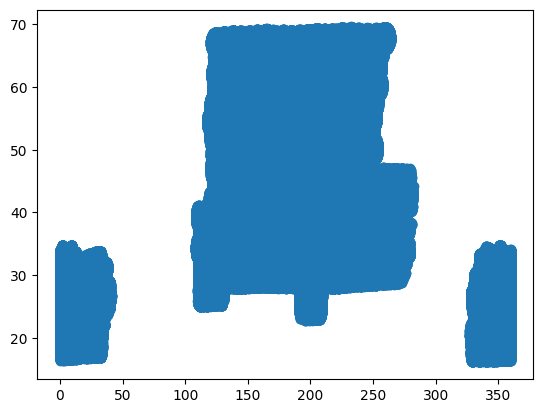

In [41]:
# get an idea what I'm looking at
print(df_lofar.head)
dec_max = df_lofar['DEC'].max()
dec_min = df_lofar['DEC'].min()
print(f"DEC min: {dec_min}, DEC max: {dec_max}")
plt.scatter(df_lofar['RA'], df_lofar['DEC'])

In [42]:
#load the FIRST dataset, which is at around 1.4 GHz

first_data_table = Table.read('folder_first/first_14dec17.fits')

df_first = first_data_table.to_pandas()

<bound method NDFrame.head of                 RA        DEC  SIDEPROB  FPEAK       FINT       RMS  MAJOR  \
0       111.892869  64.683278  0.197213   1.00   1.120000  0.139372   2.13   
1       114.663768  64.671189  0.014053   2.39   5.729300  0.139081   9.31   
2       117.600080  64.667002  0.014053  22.09  24.001633  0.139918   1.96   
3       114.690091  64.663921  0.014053   2.39   4.333272  0.139619   6.43   
4       114.886664  64.655008  0.082169   1.41   1.251983  0.139191   2.63   
...            ...        ...       ...    ...        ...       ...    ...   
946427    1.490179 -11.466122  0.865585   1.07   1.004756  0.153650   1.71   
946428    1.460987 -11.466598  0.544315   1.15   2.210556  0.156195   7.35   
946429    2.988079 -11.466975  0.014053   7.56  20.404760  0.154106  12.72   
946430   15.746366 -11.471578  0.200429   1.40   1.071304  0.154817   3.15   
946431   15.749117 -11.472486  0.059739   1.62   2.211241  0.155228   4.47   

        MINOR      POSANG  FITTED

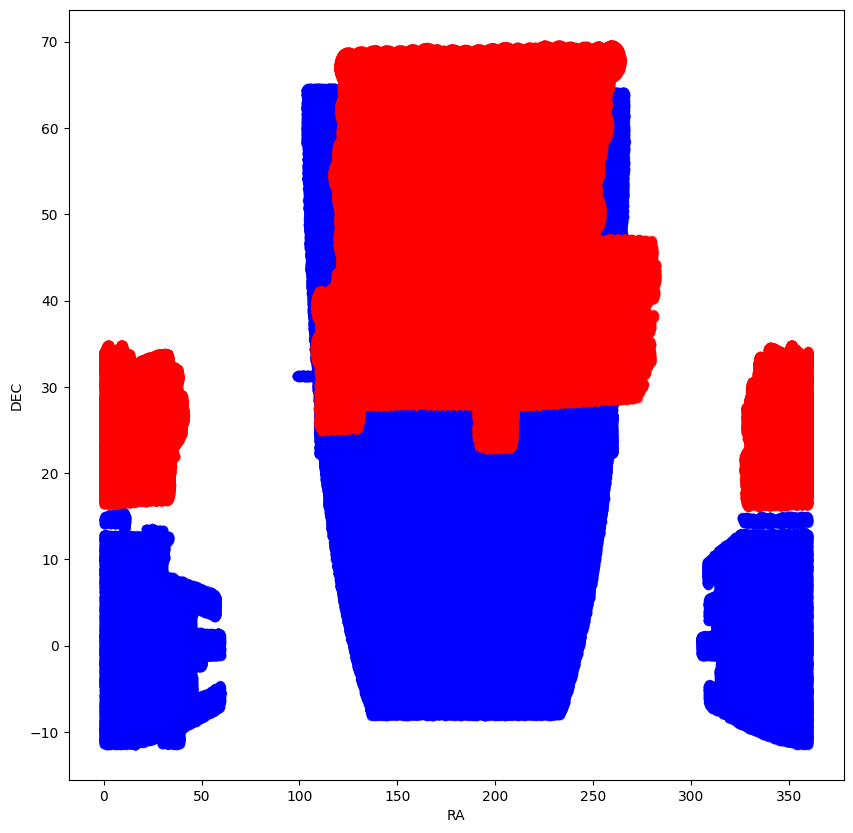

In [43]:
# same thing for the FIRST data
print(df_first.head)
fig = plt.figure(figsize=(10, 10))
subplot = fig.add_subplot(1, 1, 1)
subplot.scatter(df_first['RA'], df_first['DEC'], color = 'blue', alpha=0.5)
subplot.scatter(df_lofar['RA'], df_lofar['DEC'], color='red', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

I can pick some region that is overlapping now. Originally, I wanted to look at 3C 273 and M87, but that region isn't covered by this LOFAR set, so I'll look for another interesting region <p />
Using the NASA/IPAC extragalactic database, we can look for an interesting region that contains QSO (quasars) within our constraints (search by parameters, RA $\in$ [10h, 13h] ; DEC $\in$ [30D, 60D]) <p />
We can then plot the result from the search in the same plot after converting it into a CSV file

In [44]:
NASA_IPAC_search = pd.read_csv('NASA_IPAC_search.txt', sep = '|', skiprows=21 )
print(NASA_IPAC_search.shape)
print(df_lofar.shape)
print(df_first.shape)

(24391, 17)
(2318696, 123)
(946432, 25)


Since this is much more than I expected, I'll aim for the Coma cluster instead. First I want to figure out the area I'm aiming for

In [83]:
coma_coords = SkyCoord(ra=194.95*u.deg, dec=+27.98*u.deg) # coordinates from NASA/IPAC
coma_diameter_mly = 20
coma_distance_mly = 321
#theta = np.arctan(0.5*coma_diameter_mly / coma_distance_mly) / np.pi * 180
#print(f"theta: {theta} degrees")
# lets make this more conservative and just use 0.5 degrees and see what radius we're looking at 321 Mly away
theta = 0.5
radius = np.tan(theta * np.pi / 180) * coma_distance_mly
print(f"radius: {radius} Mly")
print(f"coma coordinates: {coma_coords}")

radius: 2.8013245608335713 Mly
coma coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (194.95, 27.98)>


In [84]:
lofar_coma = df_lofar[ (df_lofar['RA'] > coma_coords.ra.value - theta) & (df_lofar['RA'] < coma_coords.ra.value + theta) & (df_lofar['DEC'] > coma_coords.dec.value - theta) & (df_lofar['DEC'] < coma_coords.dec.value + theta) ]
print(f"LOFAR coma shape: {lofar_coma.shape}")
first_coma = df_first[ (df_first['RA'] > coma_coords.ra.value - theta) & (df_first['RA'] < coma_coords.ra.value + theta) & (df_first['DEC'] > coma_coords.dec.value - theta) & (df_first['DEC'] < coma_coords.dec.value + theta) ]
print(f"FIRST coma shape: {first_coma.shape}")
print(np.unique(lofar_coma['type']))
print(np.unique(first_coma['SDSS_CLASS']))
print((lofar_coma['RA']))

LOFAR coma shape: (431, 123)
FIRST coma shape: (109, 25)
[b'COMP' b'DEV' b'EXP' b'PSF' b'REX']
[b'-' b'g' b's']
2281945    194.451195
2282151    194.459312
2282234    194.462029
2282271    194.463293
2282281    194.463530
              ...    
2310199    195.431778
2310294    195.434687
2310306    195.435082
2310465    195.440030
2310669    195.447438
Name: RA, Length: 431, dtype: float64


At this point, I would like to futher filter the data by excluding certain types or classes from the datasets. However, my current knowledge isn't sufficient to accurately filter out AGNs based on type. That's why I'll go straight to matching coordinates.

In [115]:
import scipy

RA_LOFAR_COMA = np.array(lofar_coma['RA'] *u.deg)
DEC_LOFAR_COMA = np.array(lofar_coma['DEC'] *u.deg)
RA_FIRST_COMA = np.array(first_coma['RA'] *u.deg)
DEC_FIRST_COMA = np.array(first_coma['DEC'] *u.deg)

coords_lofar_coma = SkyCoord(ra=RA_LOFAR_COMA, dec=DEC_LOFAR_COMA, unit=(u.deg, u.deg))
coords_first_coma = SkyCoord(ra=RA_FIRST_COMA, dec=DEC_FIRST_COMA, unit=(u.deg, u.deg))

#matching the coords

index, d2d, any = coords_lofar_coma.match_to_catalog_sky(coords_first_coma)

#tolearance 
tol = 1
matched = d2d < tol * u.arcsec

# Get intersected subset
lofar_matched = lofar_coma.iloc[matched]
first_matched   = first_coma.iloc[index[matched]]
print(f"LOFAR matched shape: {lofar_matched.shape}")
print(f"FIRST matched shape: {vla_matched.shape}")

LOFAR matched shape: (22, 123)
FIRST matched shape: (22, 25)


In my opinion, this already looks promising! <p />

Quick little status update: <p />
We are looking at a 1deg x 1deg area in the direction of the coma cluster. LOFAR data has also been quality-filtered. We have then matched positions of the objects in the two catalogues, so we now have 22 pairs of objects (1 in each dataset) that are within 1 arcsecond of each other. Theta and tol are arbitrary control parameters. <p />

We can now start analyzing the 22 sources further, let's start by looking at distances 

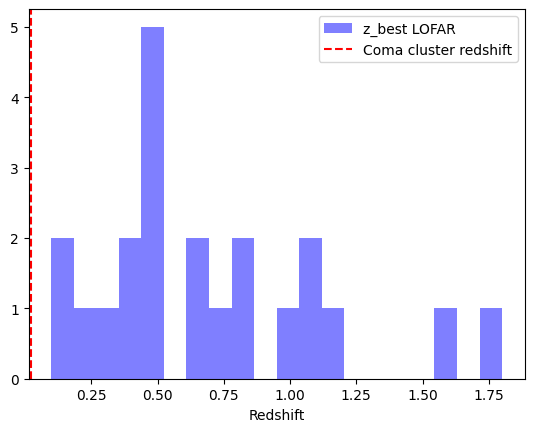

In [116]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
luminosity_distance = cosmo.luminosity_distance(lofar_matched['z_best'])

plt.hist(lofar_matched['z_best'], bins=20, color='blue', alpha=0.5, label='z_best LOFAR')
plt.axvline(x=0.023, color='red', linestyle='--', label='Coma cluster redshift')
plt.xlabel('Redshift')
plt.legend()

# Since the redshifts are orders of magnitude larger than the redshift of the coma cluster, we are not observing AGN that are part of the cluster, but behind it.
# This is consistent with the fact that there are no known AGN in the coma cluster (I think).

Unfortunately, the VLA dataset does not feature redshift values. But it is already pretty clear that these AGN are not part of the Coma Cluster

<h2>Final Result</h2>	

Now for the final result of this mini project: The Spectral indeces for the 22 objects. This is assuming that we are dealing with non-thermal radiation (i.e. synchrotron radiation from radio galaxies), which means we assume a power law $S_{\nu}=\nu^{p}$


Text(0.5, 1.0, 'Flux power law plot')

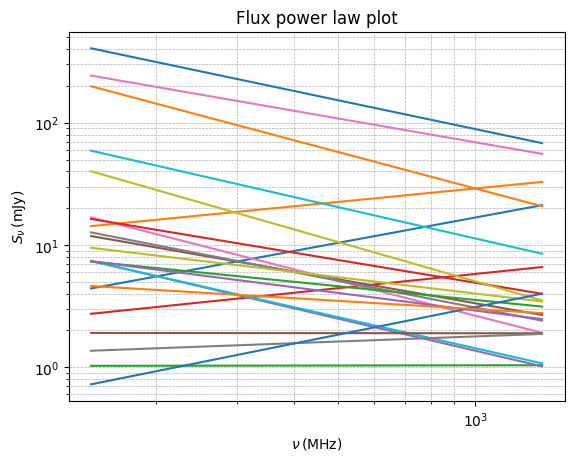

In [221]:
nu_lofar = 144 * u.MHz
nu_first = 1.4 * u.GHz

S_VLA = first_matched['FINT']
S_LOFAR = lofar_matched['Total_flux']
#Reindex, otherwise division doenst work
#S_VLA_reindex = S_VLA.reindex(S_LOFAR.index)
S_VLA_noindex = S_VLA.reset_index(drop=True)
S_LOFAR_noindex = S_LOFAR.reset_index(drop=True)


# plot data

nu_array = np.array([144, 1400])

for i in range(22):
    plt.loglog(nu_array, np.array([S_LOFAR_noindex[i], S_VLA_noindex[i]]))

plt.xlabel(r'$\nu\,(\mathrm{MHz})$')
plt.ylabel(r'$S_{\nu}\,(\mathrm{mJy})$')
plt.xscale('log')
#plt.xticks([100, 1000] , [r'$10^2$', r'$10^3$'])
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Flux power law plot')


Text(0.5, 1.0, 'Inverted: $\\alpha > 0.2$')

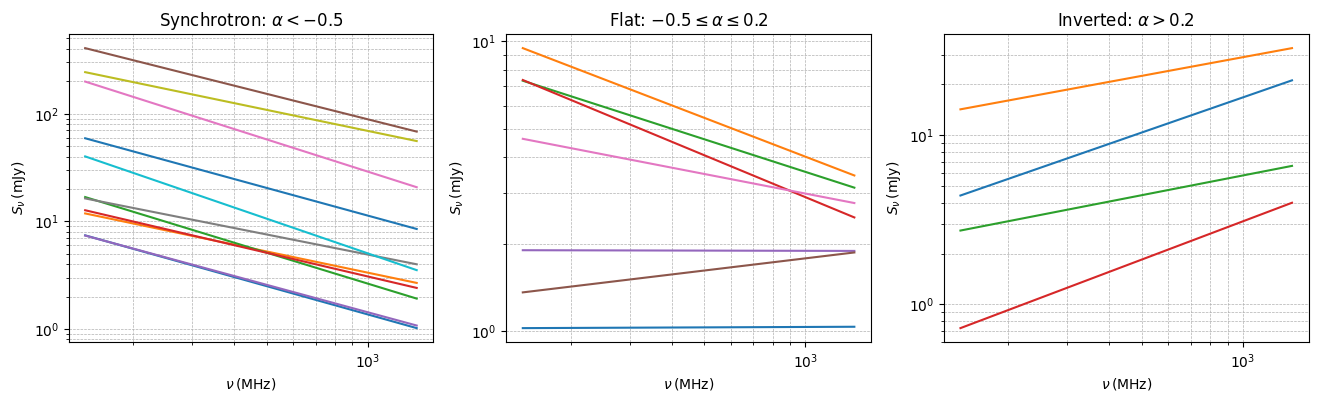

In [ ]:
Spectral_index = np.log10(S_LOFAR_noindex / S_VLA_noindex) / np.log10(nu_lofar / nu_first)

fig = plt.figure(figsize=(16, 4))
subplot0 = fig.add_subplot(1, 3, 1)
subplot1 = fig.add_subplot(1, 3, 2)
subplot2 = fig.add_subplot(1, 3, 3)
subplots = [subplot0, subplot1, subplot2]

steep_spectrum = Spectral_index < -0.5
flat_spectrum = (Spectral_index >= -0.5) & (Spectral_index <= 0.2)
inverted_spectrum = Spectral_index > 0.2
spectra = [steep_spectrum, flat_spectrum, inverted_spectrum]


for i in range(3):
    subplots[i].loglog(nu_array, np.array([S_LOFAR_noindex[spectra[i]], S_VLA_noindex[spectra[i]]]))
    subplots[i].set_xlabel(r'$\nu\,(\mathrm{MHz})$')
    subplots[i].set_ylabel(r'$S_{\nu}\,(\mathrm{mJy})$')
    subplots[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    subplots[i].set_xscale('log')
    subplots[i].set_yscale('log')

subplot0.set_title(r'Synchrotron: $\alpha < -0.5$')
subplot1.set_title(r'Flat: $-0.5 \leq \alpha \leq 0.2$')
subplot2.set_title(r'Inverted: $\alpha > 0.2$')

# Flat spectrum sources could also be AGN, especially blazars.
# Inverted sprectrum sources are likely to be star forming galaxies, as they are not expected to be AGN.

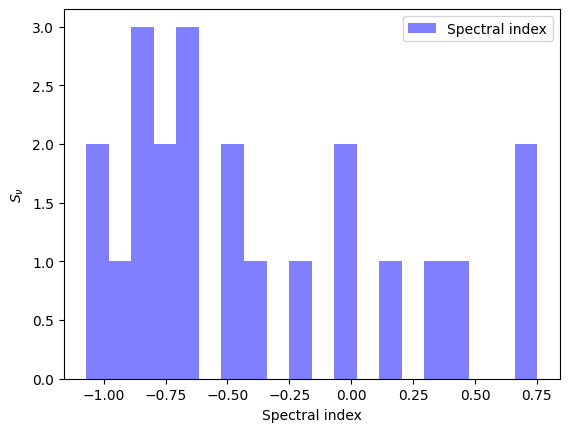

In [ ]:
Spectral_index = np.log10(S_LOFAR_noindex / S_VLA_noindex) / np.log10(nu_lofar / nu_first)

plt.hist(Spectral_index, bins=20, color='blue', alpha=0.5, label='Spectral index')
plt.xlabel('Spectral index')

plt.legend()

Let's also test for something that isn't there

Text(0.5, 1.0, 'Spectral index vs redshift')

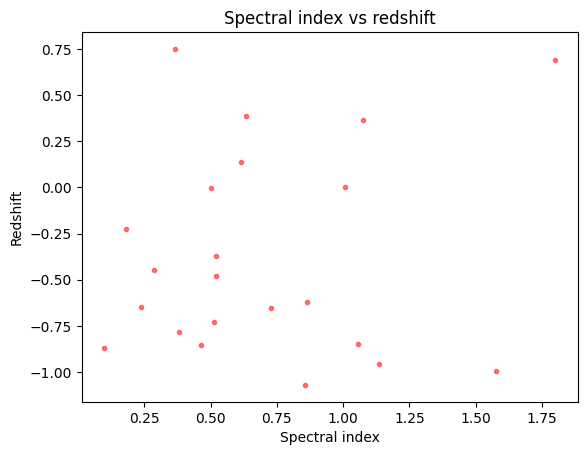

In [247]:
redshift = lofar_matched['z_best'].reset_index(drop=True)

plt.scatter(redshift, Spectral_index, color='red', alpha=0.5, marker = '.')
plt.xlabel('Spectral index')
plt.ylabel('Redshift')
plt.title('Spectral index vs redshift')